In [1]:
import numpy as np
import functools as ft
import math
import cmath
import numba
import warnings as wn
from numba import njit, prange, vectorize
from scipy.special import eval_jacobi, hyp2f1
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
# Must restrict to m_BF^2 <= m^2 <= 0 case due to boundary scaling

d = 4
m = complex(0., 1.5)
print("Using m^2 =", (m * m).real)
m_BF = - d * d / 4
if (m * m).real < m_BF:
    print("ERROR: Mass-squared must be greater than the " +
         "Breitenlohmer-Freedman bound:", m_BF)
else:
    pass
Dpl = d/2 + 0.5 * cmath.sqrt(d * d + 4.0 * m * m)
if Dpl.imag == 0: 
    Dpl = Dpl.real
else:
    print("ERROR: Must have real Delta_plus value")
                             
Dmin = d/2 - 0.5 * cmath.sqrt(d * d + 4.0 * m * m)
if Dmin.imag == 0: 
    Dmin = Dmin.real
else:
    print("ERROR: Must have real Delta_minus value")

NPOW = 15
J_0 = 1.
LMAX = 6
DX = np.pi/(2*((2**NPOW) + 1))
XGRID = np.linspace(0, np.pi/2, (2 ** NPOW) + 1, dtype=np.double) # romb method requires 2**k + 1 gridpoints
wbar = 1/4

Using m^2 = -2.25


In [3]:
# See recursion relationships between Jacobi polynomials

@njit(parallel=True)
def my_jacobi(n, a, b, x):
    if n < 0:
        return 0.
    elif n == 0:
        return J_0
    elif n == 1:
        return (a + 1) + (a + b + 2) * (x - 1) / 2
    else:
        jac_factor = 2 * n + a + b - 1
        outval = jac_factor * ((jac_factor + 1) * (jac_factor - 1) * x + (a * a)\
                               - (b * b)) * my_jacobi(n - 1, a, b, x)
        outval -= 2 * (n + a - 1) * (n + b - 1) * (jac_factor + 1) * my_jacobi(n - 2, a, b, x)
        return outval / (2 * n * (n + a + b) * (jac_factor - 1))
                    
my_jacobi(4, d/2 - 1, Dpl - d/2, np.cos(2 * np.pi/3))

-0.938100108673131

In [4]:
# Writing hypergeometric functions that utilized the numba package
# has proved to produce functions that are SLOWER than calling
# built-in functions. Below is an example of the attempt to write
# numba-compliant hypergeometric functions.

"""
# Needed in evalutating the hypergeometric functions

@njit(parallel=True)
def my_factorial(n):
    if n < 0:
        return np.inf
    elif n == 0:
        return 1
    else:
        return n * my_factorial(n - 1)
        
# Express hypergeometric function in terms a finite sum

@njit(parallel=True)
def my_2F1(a, b, c, x):
    tol = 1.E-6
    outval = 1.
    k = 1
    while(True):
        next_term = math.gamma(a + k) * math.gamma(b + k) * math.gamma(0.5 * a + 0.5 * b) * x ** k /\
            (math.gamma(a) * math.gamma(b) * math.gamma(0.5 * a + 0.5 * b + k) * my_factorial(k))
        # Failsafe
        if (k > 1E5):
            print("\nERROR: no convergence in my_2F1\n")
            break
        # When the next term is a less than the specified
        # relative tolerance, return the value
        elif (abs(next_term / outval) < tol):
            break
        # Otherwise, add to the output value, increment and repeat
        else:
            outval += next_term
            k += 1
    return outval

my_2F1((Dpl+wbar)/2, (Dpl-wbar)/2, d/2, np.sin(np.pi/4) ** 2)
    
my_factorial(3)

%timeit my_2F1((Dpl+wbar)/2, (Dpl-wbar)/2, d/2, np.sin(np.pi/4) ** 2)
9.64 µs ± 77.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
"""

'\n# Needed in evalutating the hypergeometric functions\n\n@njit(parallel=True)\ndef my_factorial(n):\n    if n < 0:\n        return np.inf\n    elif n == 0:\n        return 1\n    else:\n        return n * my_factorial(n - 1)\n        \n# Express hypergeometric function in terms a finite sum\n\n@njit(parallel=True)\ndef my_2F1(a, b, c, x):\n    tol = 1.E-6\n    outval = 1.\n    k = 1\n    while(True):\n        next_term = math.gamma(a + k) * math.gamma(b + k) * math.gamma(0.5 * a + 0.5 * b) * x ** k /            (math.gamma(a) * math.gamma(b) * math.gamma(0.5 * a + 0.5 * b + k) * my_factorial(k))\n        # Failsafe\n        if (k > 1E5):\n            print("\nERROR: no convergence in my_2F1\n")\n            break\n        # When the next term is a less than the specified\n        # relative tolerance, return the value\n        elif (abs(next_term / outval) < tol):\n            break\n        # Otherwise, add to the output value, increment and repeat\n        else:\n            outval

In [ ]:
%timeit hyp2f1((Dpl+wbar)/2, (Dpl-wbar)/2, d/2, np.sin(np.pi/4) ** 2)

In [4]:
@njit(parallel=True)
def mu(x):
    return (np.tan(x)) ** (d-1)

# Evaluate the derivatives analytically
@njit(parallel=True)
def nu(x):
    return (np.cos(x)) ** 2 * (np.tan(x)) ** (2 - d)

@njit(parallel=True)
def nup(x):
    return (1 - d + np.cos(2.*x)) * (np.tan(x)) ** (1 - d) 

@njit(parallel=True)
def omega(i):
    return Dpl + 2 * i
mu(0)
nu(np.pi)
nup(np.pi/4)
omega(0)

3.3228756555322954

In [5]:
@njit(parallel=True)
def K(i):
    return 2. * np.sqrt((i + Dpl / 2) * math.gamma(i + 1) * math.gamma(Dpl + i) / (math.gamma(i + d/2) * math.gamma(
        i + Dpl + 1 - d/2)))

K(1)

4.205621705906722

In [6]:
# Since basis functions will be called with either integer arguments (normalizable) or
# non-integer arguments (non-normalizable), write one basis function that returns
# either of these types based on the integer nature of the argument

def e(x, i):
    # If integer is passed, return normalizable solution
    if (i % 1 == 0):
        return K(i) * (np.cos(x)) ** Dpl * my_jacobi(i, d/2 - 1, Dpl - d/2, np.cos(2 * x))
    # Otherwise, return NN solution
    else:
        return (np.cos(x)) ** Dpl * hyp2f1((Dpl + i) / 2, (Dpl - i) / 2, d / 2, (np.sin(x)) ** 2)
    
e(np.pi/4, 0.25)

0.8142285341830124

In [7]:
# Same thing for the derivatives

def ep(x, i):
    if (i % 1 == 0):
        return -1. * K(i) * np.tan(x) * (np.cos(x)) ** Dpl * (2 * (Dpl + i) * np.cos(x) ** 2 * my_jacobi(i - 1, 
            d/2, Dpl + 1 - d/2, np.cos(2 * x)) + Dpl * my_jacobi(i, d/2 - 1, Dpl - d/2, np.cos(2 * x)))
    else:
        return (1. / d) * np.tan(x) * np.cos(x) ** Dpl * ((Dpl ** 2 - i ** 2) * np.cos(x) ** 2 *\
                hyp2f1(1 + 0.5 * (Dpl - i), 1 + 0.5 * (Dpl + i), 1 + 0.5 * d, (np.sin(x)) ** 2)\
                - d * Dpl * hyp2f1(0.5 * (Dpl - i), 0.5 * (Dpl + i), d/2, (np.sin(x)) ** 2))
    
ep(np.pi/3, 1)

1.4312318500742816

In [8]:
# Without parallelizing options, regular scipy integration methods
# outperform approximators by orders of magnitude

# Try to catch convergence problems in integrals and switch to higher
# resolution options

wn.filterwarnings("error")

def X(i,j,k,l):
    def integrand(x, i, j, k, l):
        return mu(x) * np.sin(x) * np.cos(x) * ep(x, i) * e(x, j) * e(x, k) * e(x, l)
    try:
        return integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l))[0]
    except IntegrationWarning:
        result = integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l), limit=100)
        print("X(%f,%f,%f,%f):" % (i,j,k,l), result)
        return result[0]

def Y(i,j,k,l):
    def integrand(x, i, j, k, l):
        return mu(x) * np.sin(x) * np.cos(x) * ep(x, i) * ep(x, j) * e(x, k) * ep(x, l)
    try:
        return integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l))[0]
    except IntegrationWarning:
        result = integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l), limit=100)
        print("Y(%f,%f,%f,%f):" % (i,j,k,l), result)
        return result[0]

def V(i,j,k,l):
    def integrand(x, i, j, k, l):
        return mu(x) * np.sin(x) * np.cos(x) * e(x, i) * e(x, j) * ep(x, k) * e(x, l) * (1 / np.cos(x)) ** 2
    try:
        return integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l))[0]
    except IntegrationWarning:
        result = integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l), limit=100)
        print("V(%f,%f,%f,%f):" % (i,j,k,l), result)
        return result[0]

def B(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return np.sin(x) * np.cos(x) * ep(x, i) * ep(x, j) * mu(y) * e(y, l) * e(y, l)
    # Use built-in double integrator with dynamic bounds
    try:
        return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]
    except integrate.IntegrationWarning:
        result = integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l),
                               epsrel=1.0e-6)
        print("B(%f,%f,%f):" % (i,j,l), result)
        return result[0]

def P(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return np.sin(x) * np.cos(x) * e(x, i) * e(x, j) * mu(y) * e(y, l) * e(y, l)
    # Use built-in double integrator with dynamic bounds
    try:
        return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]
    except integrate.IntegrationWarning:
        result = integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l),
                                  epsrel=1.0e-6)
        print("P(%f,%f,%f):" % (i,j,l), result)
        return result[0]

def Q(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return np.sin(x) * np.cos(x) * e(x, i) * e(x, j) * (1/ np.cos(x)) ** 2 * mu(y) * e(y, l) * e(y, l)
    # Use built-in double integrator with dynamic bounds
    try:
        return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]
    except integrate.IntegrationWarning:
        result = integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l),
                                  epsrel=1.0e-6)
        print("Q(%f,%f,%f):" % (i,j,l), result)
        return result[0]
    
def M(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return mu(x) * nup(x) * ep(x, i) * e(x, j) * mu(y) * e(y, l) * e(y,l)
    # Use built-in double integrator with dynamic bounds
    try:
        return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]
    except integrate.IntegrationWarning:
        result = integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l),
                                  epsrel=1.0e-6)
        print("M(%f,%f,%f):" % (i,j,l), result)
        return result[0]

print("X(%f,%f,%f,%f) = %e" % (1,1,1,1, X(1,1,1,1)))
print("Y(%f,%f,%f,%f) = %e" % (0,0.25,0.25,0, Y(0,0.25,0.25,0)))
print("V(%f,%f,%f,%f) = %e" % (0.5,0.5,1,1, V(0.5,0.5,1,1)))
print("B(%f,%f,%f) = %e" % (1,0.25,2, B(1,0.25,2)))
print("P(%f,%f,%f) = %e" % (1,0.5,3, P(1,0.5,3)))
print("Q(%f,%f,%f) = %e" % (0.75,2,1, Q(0.75,2,1)))
print("M(%f,%f,%f) = %e" % (0.25,2,1, M(0.25,2,1)))

X(1.000000,1.000000,1.000000,1.000000) = -9.330355e+00
Y(0.000000,0.250000,0.250000,0.000000) = -2.906455e+00
V(0.500000,0.500000,1.000000,1.000000) = -2.389242e+00
B(1.000000,0.250000,2.000000) = 2.120319e-01
P(1.000000,0.500000,3.000000) = 1.043301e-01
Q(0.750000,2.000000,1.000000) = 2.672686e-02
M(0.250000,2.000000,1.000000) = 8.952125e-02


In [29]:
%timeit V_temp(0.5, 0.5, 1, 1)

NameError: name 'V_temp' is not defined

In [9]:
# NB. May be passing non-integer indices for i, j, or k.

def H(i,j,k,l):
    # Only i and k need to be tested as integers
    if (i % 1 == 0):
        if (k % 1 == 0):
            return omega(i) ** 2 * X(k,i,j,l) + omega(k) ** 2 * X(i,j,k,l) \
                    - Y(i,j,l,k) - Y(l,k,j,i) - (m * m).real * (V(i,j,k,l) + V(k,j,i,l))
        else:
            return omega(i) ** 2 * X(k,i,j,l) + k ** 2 * X(i,j,k,l) \
                    - Y(i,j,l,k) - Y(l,k,j,i) - (m * m).real * (V(i,j,k,l) + V(k,j,i,l))
    elif (i % 1 != 0):
        if (k % 1 == 0):
            return i ** 2 * X(k,i,j,l) + omega(k) ** 2 * X(i,j,k,l) \
                    - Y(i,j,l,k) - Y(l,k,j,i) - (m * m).real * (V(i,j,k,l) + V(k,j,i,l))
        else:
            return i ** 2 * X(k,i,j,l) + k ** 2 * X(i,j,k,l) \
                    - Y(i,j,l,k) - Y(l,k,j,i) - (m * m).real * (V(i,j,k,l) + V(k,j,i,l))
    else:
        print("\nERROR: Failure to parse arguments in H\n")

def Zpl(i,j,k,l):
    # Only i and j need to be tested
    if (i % 1 == 0):
        if (j % 1 == 0):
            return omega(i) * omega(j) * (X(k,l,i,j) - X(l,k,i,j)) \
                    + (Y(i,j,l,k) - Y(i,j,k,l))
        else:
            return omega(i) * j * (X(k,l,i,j) - X(l,k,i,j)) \
                    + (Y(i,j,l,k) - Y(i,j,k,l))
    elif (i % 1 != 0):
        if (j % 1 == 0):
            return i * omega(j) * (X(k,l,i,j) - X(l,k,i,j)) \
                    + (Y(i,j,l,k) - Y(i,j,k,l))
        else:
            return i * j * (X(k,l,i,j) - X(l,k,i,j)) \
                    + (Y(i,j,l,k) - Y(i,j,k,l))
    else:
        print("\nERROR: Failure to parse arguments in Zpl\n")

def Zmin(i,j,k,l):
    # Only i and j need to be tested
    if (i % 1 == 0):
        if (j % 1 == 0):
            return omega(i) * omega(j) * (X(k,l,i,j) - X(l,k,i,j)) \
                    - (Y(i,j,l,k) - Y(i,j,k,l))
        else:
            return omega(i) * j * (X(k,l,i,j) - X(l,k,i,j)) \
                    - (Y(i,j,l,k) - Y(i,j,k,l))
    elif (i % 1 != 0):
        if (j % 1 == 0):
            return i * omega(j) * (X(k,l,i,j) - X(l,k,i,j)) \
                    - (Y(i,j,l,k) - Y(i,j,k,l))
        else:
            return i * j * (X(k,l,i,j) - X(l,k,i,j)) \
                    - (Y(i,j,l,k) - Y(i,j,k,l))
    else:
        print("\nERROR: Failure to parse arguments in Zmin\n")
        
def Zpl_tilde(i,j,l):
    # Only i and j need to be tested
    if (i % 1 == 0):
        if (j % 1 == 0):
            return omega(i) * omega(j) * P(i,j,l) + B(i,j,l)
        else:
            return omega(i) * j * P(i,j,l) + B(i,j,l)
    elif (i % 1 != 0):
        if (j % 1 == 0):
            return i * omega(j) * P(i,j,l) + B(i,j,l)
        else:
            return i * j * P(i,j,l) + B(i,j,l)
    else:
        print("\nERROR: Failure to parse arguments in Zpl_tilde\n")

def Zmin_tilde(i,j,l):
    # Only i and j need to be tested
    if (i % 1 == 0):
        if (j % 1 == 0):
            return omega(i) * omega(j) * P(i,j,l) - B(i,j,l)
        else:
            return omega(i) * j * P(i,j,l) - B(i,j,l)
    elif (i % 1 != 0):
        if (j % 1 == 0):
            return i * omega(j) * P(i,j,l) - B(i,j,l)
        else:
            return i * j * P(i,j,l) - B(i,j,l)
    else:
        print("\nERROR: Failure to parse arguments to Zmin_tilde\n")


In [ ]:
# Test values of basis functions by comparing the source term for +++ resonances
# in the normalizable case computed using the non-/normalizable basis functions
# (See DrivenTTF_NormalizableResonances for this calculation)

# Values are consistant with zero up to round off error

"""
def Omega(i,j,k,l):
    return (-1./12) * H(i,j,k,l) * omega(j) * (omega(i) + omega(k) +        
        2 * omega(j)) / ((omega(i) + omega(j)) * (omega(j) + omega(k))) \
        - (1./12) * H(i,k,j,l) * omega(k) * (omega(i) + omega(j) + 
        2 * omega(k)) / ((omega(i) + omega(k)) * (omega(j) + omega(k))) \
        - (1./12) * H(j,i,k,l) * omega(i) * (omega(j) + omega(k) + 
        2 * omega(i)) / ((omega(i) + omega(j)) * (omega(i) + omega(k))) \
        - (1./12) * m ** 2 * V(i,j,k,l) * (1 + omega(j) / (omega(j) + omega(k))
        + omega(i) / (omega(i) + omega(k))) \
        - (1./12) * m ** 2 * V(j,k,i,l) * (1 + omega(j) / (omega(i) + omega(j))
        + omega(k) / (omega(i) + omega(k))) \
        - (1./12) * m ** 2 * V(k,i,j,l) * (1 + omega(i) / (omega(i) + omega(j))
        + omega(k) / (omega(j) + omega(k))) \
        + (1./6) * X(j,k,i,l) * omega(i) * omega(k) * (1 + omega(i) / (omega(j)
        + omega(k)) + omega(k) / (omega(i) + omega(j))) \
        + (1./6) * X(k,i,j,l) * omega(i) * omega(j) * (1 + omega(i) / (omega(j) 
        + omega(k)) + omega(j) / (omega(i) + omega(k))) \
        + (1./6) * X(i,j,k,l) * omega(j) * omega(k) * (1 + omega(j) / (omega(i) 
        + omega(k)) + omega(k) / (omega(i) + omega(j))) \
        - (1./12) * Zmin(i,j,k,l) * omega(k) / (omega(i) + omega(j)) \
        - (1./12) * Zmin(i,k,j,l) * omega(j) / (omega(i) + omega(k)) \
        - (1./12) * Zmin(j,k,i,l) * omega(i) / (omega(j) + omega(k))

Dpl = 4
for l in range(6):
    for i in range(6):
        for j in range(6):
            if (l - i - j - Dpl >= 0):
                print("O(%d,%d,%d,%d) = %e" % (i,j,l-i-j-Dpl,l,Omega(i, j, l - i - j - Dpl, l)))
            else:
                pass
"""

In [10]:
# Source term for equal, general NN frequencies

def Tbar(w, l):
    # Special case for when NN frequency equals resonant frequency
    if w == 2 * l + d:
        return 3.0 * Y(l,l,l,l) + (omega(l) ** 2) * (B(l,l,l) - (omega(l) ** 2) * P(l,l,l)) \
                - 2 * (m * m).real * omega(l) ** 2 * Q(l,l,l) \
                - 5 * (m * m).real * V(l,l,l,l) / 5
    else:
        return 0.5 * Zmin(l,w,w,l) * w / (omega(l) + w) \
                + 0.5 * Zpl(l,w,w,l) * w / (omega(l) - w) \
                - omega(l) ** 2 * H(w,l,w,l) / (omega(l) ** 2 - w ** 2) \
                + w ** 2 * H(w,w,l,l) / (omega(l) ** 2 - w ** 2) \
                + 2 * w ** 2 * X(w,w,l,l) + 2 * w ** 2 * omega(l) ** 2 /\
                (omega(l) ** 2 - w ** 2) - w ** 2 * X(l,l,w,w) - \
                2 * X(l,l,w,w) * w ** 4 / (omega(l) ** 2 - w ** 2) \
                + (m * m).real * V(w,w,l,l) * w ** 2 / (omega(l) ** 2 - w ** 2) \
                - (m * m).real * V(l,l,w,w) * omega(l) ** 2 / (omega(l) ** 2 - w ** 2) \
                - 2 * (m * m).real * V(l,l,w,w) \
                - 0.5 * (m * m).real * V(w,w,l,l) \
                + 2 * omega(l) ** 2 * Zpl_tilde(w,w,l) - H(w,w,l,l) - \
                4 * w ** 2 * omega(l) ** 2 * P(l,l,w) - \
                2 * w ** 2 * M(l,l,w) \
                - 2 * (m * m).real * w ** 2 * Q(l,l,w)

# NB. Resistrictions on the value of w?
def Source(w, l):
    if w <= 0.:
        print("\nERROR: Frequency of NN modes must be greater than or equal to zero.\n")
        return None
    else:
        outval = np.zeros((l + 1,), dtype=np.double)
        for i in range(l + 1):
            outval[i] += Tbar(w,i)
            #print("S[%d] = %e" % (i, outval[i]))
        #print("Sum_0^%d S_i = %e" % (l, np.sum(outval)))
        return outval

Source(0.1, 3)

array([ 3.68291815,  8.52716065, 15.73881991, 25.27292174])

In [30]:
# Scan through some non-integer NN mode frequencies to see the effect on
# the value of the source term
# NN frequency must be greater than 0
wvals = [0.1, 0.5, 1.0, 1.5, 2.0, 3.75, 4.0, 4.1]
datafile = "NNEqualFrequencies_m" + str((m * m).real) + ".dat"
with open(datafile, "w") as f:
    for val in wvals:
        result = Source(val, 10)
        f.write("Computing source terms for NN mode frequency w = {:f}".format(val) +
                " up to l = 10\n")
        for i in range(len(result)):
            # print("S[%d] = %e" % (i, result[i]))
            f.write("S[" + str(i) + "] = {:e}\n".format(result[i]))
        f.write("Sum_0^{:d} = ".format(len(result)) + "{:e}\n".format(np.sum(result)))

{0.1: [3.682918, 8.527161, 15.73882, 25.27292, 37.11606, 51.26308, 67.71161, 86.46042, 107.5088, 130.8564], 0.5: [4.435781, 9.901041, 17.90309, 28.45683, 41.55789, 57.20362, 75.39262, 96.12408, 119.3975, 145.2127], 1.0: [447.9487, 1680.443, 3419.931, 5514.979, 8068.826, 11101.87, 14620.01, 18625.6, 23119.78, 28103.14], 1.5: [10.7857, 19.34396, 31.43456, 47.47532, 67.42601, 91.26836, 118.9943, 150.6, 186.0832, 225.4428], 2.0: [872.5166, 2989.781, 7131.041, 12477.96, 18508.14, 25533.23, 33631.8, 42828.2, 53132.9, 64551.1], 3.75: [-124.1935, 75.31981, 67.10128, 77.11197, 94.15679, 116.1761, 142.5347, 172.9775, 207.3847, 245.6932], 4.0: [-53.39977, 7753.845, 15041.8, 28295.22, 48380.82, 72125.15, 96930.89, 124244.8, 154494.5, 187824.5], 4.1: [-79.79223, 103.956, 77.45172, 83.15315, 97.6721, 117.5511, 141.793, 170.0106, 202.0254, 237.7446]}
{0.1: 690.641, 0.5: 769.1544, 1.0: 148278.5, 1.5: 1217.532, 2.0: 338742.4, 3.75: 1362.13, 4.0: 959339.3, 4.1: 1428.682}
Saved figure as NN_equalfreq_sou

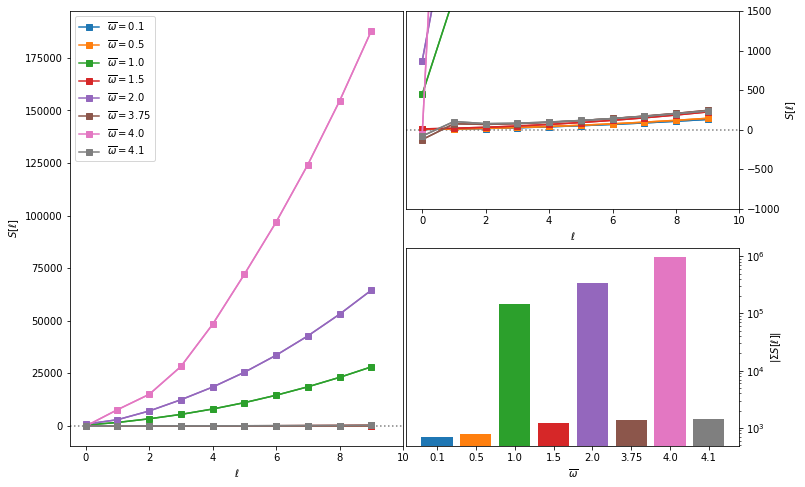

In [31]:
# Plot the results
svals = {}
totalvals = {}
# Read the data from the file. Dictionary key is the NN frequency, values are source terms S[l]
with open("NNEqualFrequencies_m-2.25.dat", "r") as f:
    lmax = 0
    tmp = []
    for line in f:
        # Read the line that contains the NN frequency value and the number of modes
        if "w =" in line:
            foo = line.strip().split(" = ")
            # Pick out the w value
            dkey = float(foo[1].split()[0])
            # Pick out the l value
            lmax = int(foo[-1])
        # Catch the sum of the source terms and store in separate dictionary
        elif "Sum" in line:
            tsum = line.strip().split(" = ")
            totalvals[dkey] = float(tsum[-1])
        # Otherwise, add the value to the list for that frequency
        else:
            if lmax <= 0:
                #print("Adding element to dictionary:")
                #print("svals[%s] = " % dkey)
                #print(tmp)
                svals[dkey] = tmp
                lmax = 0
                tmp = []
            else:
                bar = line.strip().split()
                tmp.append(float(bar[-1]))
                lmax -= 1

print(svals)
print(totalvals)

colours = ['C' + str(val) for val in range(10)] * int((len(svals) - 1)/10 + 1)
fig = plt.figure(figsize=(12,8))
gs = GridSpec(2,2,figure=fig,wspace=0.01, hspace=0.2)
ax1 = fig.add_subplot(gs[:,:1])
ax2 = fig.add_subplot(gs[1,-1:])
ax3 = fig.add_subplot(gs[0,-1:])

# Plot the source terms S[l]
ii = 0
for key in sorted(svals.keys()):
    # Test for nan values caused by division by zero
    if np.any(np.isnan(svals.get(key))):
        temp = svals.get(key)
        xvals = np.arange(len(temp))
        nanvals = np.argwhere(np.isnan(temp))
        # Remove nan values and adjust arrays accordingly
        for indx in nanvals[0]:
            print("NAN value detected:", temp)
            temp = np.delete(temp, [indx])
            xvals = np.delete(xvals, [indx])
        # Recalculate sum with nan values removed
        totalvals[key] = np.sum(temp)
        # Plot adjusted source terms
        for ax in ax1,ax3:
            ax.plot(xvals, temp, marker='s', markerfacecolor=colours[ii], 
                 label=r'$\overline{\omega} = $' + str(key))
            ax.plot(xvals, temp, color=colours[ii])
        
    else:
        for ax in ax1,ax3:
            ax.plot(np.arange(len(svals.get(key))), svals.get(key)[:], marker='s', markerfacecolor=colours[ii], 
                 label=r'$\overline{\omega} = $' + str(key))
            ax.plot(np.arange(len(svals.get(key))), svals.get(key)[:], color=colours[ii])
    ii += 1
    
# Plot axis labels and reference line
for ax in ax1,ax3:
    ax.hlines(0, -0.5, 10, colors='black', linestyle='dotted', alpha=0.5)
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$S[\ell]$')
    
ax3.set_ylim(-1000,1500)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax1.legend()

# Plot sum of source terms up to LMAX
sources = [str(key) for key in sorted(totalvals.keys())]

sums = [abs(totalvals.get(key)) for key in sorted(totalvals.keys())]
x_pos = np.arange(len(sources))
ax2.bar(x_pos, sums, color=colours[:len(sources)])
ax2.set_xticks(x_pos)
ax2.set_xticklabels(sources)
ax2.set_yscale('log')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(r'$|\Sigma S[\ell]|$')
ax2.set_xlabel(r'$\overline{\omega}$')

for ax in ax1,ax3:
    ax.set_xlim(-0.5,10)

fname = "NN_equalfreq_sourceterms_m-2.25.pdf"
plt.savefig("figures/" + fname, transparent=True, format="pdf")
print("Saved figure as", fname)
plt.show()


In [32]:
# Sources for (++) of two NN frequencies adding to an integer

#####################################################
## If either w1 or w2 is an integer, are the X, Y  ##
##  functions returning the correct NN functions?  ##
## How to test for this? Write separate functions? ##
#####################################################

def R_pp(i, w1, w2, l):
    n = (w1 + w2) / 2
    out = - (1. / 6.) * (Zmin(i, w1, w2, l) * w2 / (omega(l) - w2) + Zmin(i, w2, w1, l) * w1 / (omega(l) - w1) \
            + Zmin(w1, w2, i, l) * (omega(l) - 2 * n) / (2 * n) + w1 * w2 * X(i, w1, w2, l) \
            + (omega(l) - 2 * n) * (w2 * X(w1, i, w2, l) + w1 * X(w2, i, w1, l)) \
            - 0.5 * (m * m).real * (V(w1, w2, i, l) + V(i, w1, w2, l) + V(i, w2, w1, l)))
    if omega(i) != w1:
        out -= (1. / 6.) * (w2 * (H(i, w2, w1, l) - (m * m).real * V(w2, w1, i, l) - \
                2 * w2 ** 2 * X(i, w1, w2, l)) / (omega(l) - w1) + (omega(l) - 2 * n) * (H(w1, i, w2, l) + \
                (m * m).real * V(i, w2, w1, l) - 2 * w2 ** 2 * X(w1, i, w2, l)) / (omega(l) - w2))
    if omega(i) != w2:
        out -= (1. / 6.) * (w1 * (H(i, w2, w1, l) + (m * m).real * V(w2, w1, i, l) - \
                2 * w1 ** 2 * X(i, w2, w1, l)) / (omega(l) - w2) + (omega(l) - 2 * n) * (H(w2, i, w1, l) + \
                (m * m).real * V(i, w1, w2, l) - 2 * w1 ** 2 * X(w2, i, w1, l)) / (omega(l) - w1))
    if w1 != w2:
        out -=  (w1 * H(w2, w1, i, l) + w2 * H(w1, w2, i, l) + (m * m).real * (w1 * V(w1, i, w2, l) + \
                w2 * V(w2, i, w1, l)) - 2 * (omega(l) - 2 * n) ** 2 * (w1 * X(w2, w1, i, l) + \
                w2 * X(w1, w2, i, l))) / (12 * n)
    return out

def R_pm(i, w1, w2, l):
    n = (w1 + w2) / 2
    out = - (1. / 4.) * ((omega(l) + 2 * n) * Zmin(w1, w2, i, l) / (2 * n) + 2 * (omega(l) + 2 * n) * \
            (w1 * X(w2, w1, i, l) + w2 * X(w1, w2, i, l)) - 2 * w1 * w2 * X(i, w1, w2, l) + \
            (m * m).real * (V(w1, w2, i, l) + V(i, w1, w2, l) + V(i, w2, w1, l)) \
            - w1 * (H(i, w1, w2, l) + (m * m).real * V(w1, w2, i, l) - \
                2 * w2 ** 2 * X(i, w1, w2, l)) / (omega(l) + w2) \
            + (omega(l) + 2 * n) * (H(w1, i, w2, l) + (m * m).real * V(i, w2, w1, l) - \
                2 * w2 ** 2 * X(w1, i, w2, l)) / (omega(l) + w2) \
            - w2 * (H(i, w2, w1, l) + (m * m).real * V(w2, w1, i, l) - \
                2 * w1 ** 2 * X(i, w2, w1, l)) / (omega(l) + w1) \
            + (omega(l) + 2 * n) * (H(w2, i, w1, l) + (m * m).real * V(i, w1, w2, l) - \
                2 * w1 ** 2 * X(w2, i, w1, l)) / (omega(l) + w1))
    if w2 != omega(l):
        out += w1 * w2 * (omega(l) + 2 * n) * (X(w2, w1, i, l) - X(l, i, w1, w2)) / (omega(l) + w2)
    if w1 != omega(l):
        out += w1 * w2 * (omega(l) + 2 * n) * (X(w1, w2, i, l) - X(l, i, w2, w1)) / (omega(l) + w1)
    return out
    
def R_mp(i, w1, w2, l):
    n = (w1 + w2) / 2
    out = - (1. / 2.) * ((2 * n - omega(l)) * (w1 * X(w2, w1, i, l) + w2 * X(w1, w2, i, l)) \
            - w1 * w2 * X(i, w1, w2, l))
    if w1 != omega(l):
        out += (1. / 4.) * (w1 * Zpl(w2, i, w1, l) - w2 * (H(i, w2, w1, l) - 2 * w1 ** 2 * X(i, w2, w1, l)) \
                + (2 * n - omega(l)) * (H(w2, i, w1, l) - 2 * w1 ** 2 * X(w2, i, w1, l))) / (omega(l) - w1)
    if w2 != omega(l):
        out += (1. / 4.) * (w2 * Zpl(w1, i, w2, l) - w1 * (H(i, w2, w1, l) - 2 * w2 ** 2 * X(i, w1, w2, l)) \
                + (2 * n - omega(l)) * (H(w1, i, w2, l) - 2 * w2 ** 2 * X(w1, i, w2, l))) / (omega(l) - w2)
    if w1 != w2:
        out -= ((2 * n - omega(l)) * (w1 * X(w2, w1, i, l) + w2 * X(w1, w2, i, l)) \
                - w1 * w2 * X(i, w1, w2, l)) / (8 * n)
    return out

def Tee(w1, w2, l):
    n = (w1 + w2) / 2
    return 0.5 * omega(l) ** 2 * (Zpl_tilde(w1, w1, l) + Zpl_tilde(w2, w2, l)) - 0.5 * (H(w1, w1, l, l) \
            + H(w2, w2, l, l) + (m * m).real * (V(l, w1, w1, l) + V(l, w2, w2, l)) \
            - 2 * omega(l) ** 2 * (X(w1, w1, l, l) + X(w2, w2, l, l)) \
            + 4 * omega(l) ** 2 * (w1 ** 2 * P(l, l, w1) + w2 ** 2 * P(l, l, w2)) + 2 * w1 ** 2 * M(l, l, w1) \
            + 2 * w2 ** 2 * M(l, l, w2) + 2 * (m * m).real * (w1 ** 2 * Q(l, l, w1) + w2 ** 2 * Q(l, l, w2))) 
                                                          

In [33]:
# Give an input value of even integer 2n and sum over 
# possible values of w1 and w2

def atoi_pp_Source(n, w1, Lmax):
    if (n % 1 != 0):
        print("ERROR: n must be an integer")
        return None
    else:
        w2 = 2*n - w1
        outval = np.zeros((Lmax + 1,), dtype=np.double)
        for l in range(Lmax + 1):
            outval[l] += Tee(w1, w2, l) + R_pm(l + n, w1, w2, l)
            if l - n >= 0:
                outval[l] += R_pp(l - n, w1, w2, l)
            if n - l - d >= 0:
                outval += R_mp(n - l - d, w1, w2, l)
            print("S[%d] = %e" % (l, outval[l]))
        print("Sum_0^%d = %e" % (Lmax, np.sum(outval)))
    return outval

atoi_pp_Source(2,0.5,10)        

array([ 0.        ,  0.        , -0.11199924, -0.06423686, -0.24146282,
       -0.5450172 , -0.88422575, -1.23716494, -1.59481915, -1.95266685,
       -2.3081628 ])

In [21]:
# Examine different values of n by scanning over
# NN frequency values that add to 2n

# Try a step size for NN frequencies -- technically an infinite number of terms?
wstep = 0.25
n = 2
w1 = np.arange(wstep, 2*n, wstep)
datafile = "NNAddToInteger_n" + str(n) + "_m" + str((m * m.conjugate()).real) + ".dat"
with open(datafile, "w") as f:
    for val1 in w1:
        prog = 100 - (w1[-1] - val1) / (w1[-1] - w1[0]) * 100
        print('\rPercent complete: ' + '{:03.1f}'.format(prog) + '%', end='\r')
        result = atoi_pp_Source(n, val1, 10)
        if result is None:
            pass
        else:
            f.write("Computing source terms for two NN modes with w1 = {:f}".format(val1) +
                        " and w2 = {:f}".format(2*n - val1) + " up to l = 10\n")
            for i in range(len(result)):
                f.write("S[" + str(i) + "] = {:e}\n".format(result[i]))
            f.write("Sum_0^{:d} = ".format(len(result)) + "{:e}\n".format(np.sum(result)))
    print("Wrote data to", f.name)

Wrote data to NNAddToInteger_n2_m0.25.dat


{(0.1, 3.9): [-0.06964965, -0.1089194, -0.229509, -0.3315306, -0.4569073, -0.6057042, -0.7777528, -0.9729528, -1.191249, -1.432608], (0.2, 3.8): [-0.1230008, -0.1953704, -0.4116403, -0.5986925, -0.8279072, -1.09969, -1.413828, -1.770176, -2.168652, -2.609205], (0.3, 3.7): [-0.1616293, -0.2606429, -0.549168, -0.8039526, -1.115387, -1.484357, -1.910686, -2.394226, -2.934886, -3.532611], (0.4, 3.6): [-0.1871665, -0.3062776, -0.6453669, -0.950696, -1.323107, -1.763993, -2.273268, -2.850804, -3.496517, -4.210353], (0.5, 3.5): [-0.2012699, -0.3340326, -0.7039481, -1.043157, -1.456121, -1.9447, -2.508914, -3.148673, -3.863906, -4.654568], (0.6, 3.4): [-0.2055948, -0.3458466, -0.7289869, -1.08633, -1.520679, -2.034262, -2.627211, -3.299477, -4.051006, -4.881764], (0.7, 3.3): [-0.2017703, -0.343799, -0.7248447, -1.085859, -1.524079, -2.041977, -2.63978, -3.317481, -4.075047, -4.912452], (0.8, 3.2): [-0.191376, -0.3300677, -0.6960862, -1.047918, -1.474505, -1.978432, -2.56, -3.219237, -3.956128,

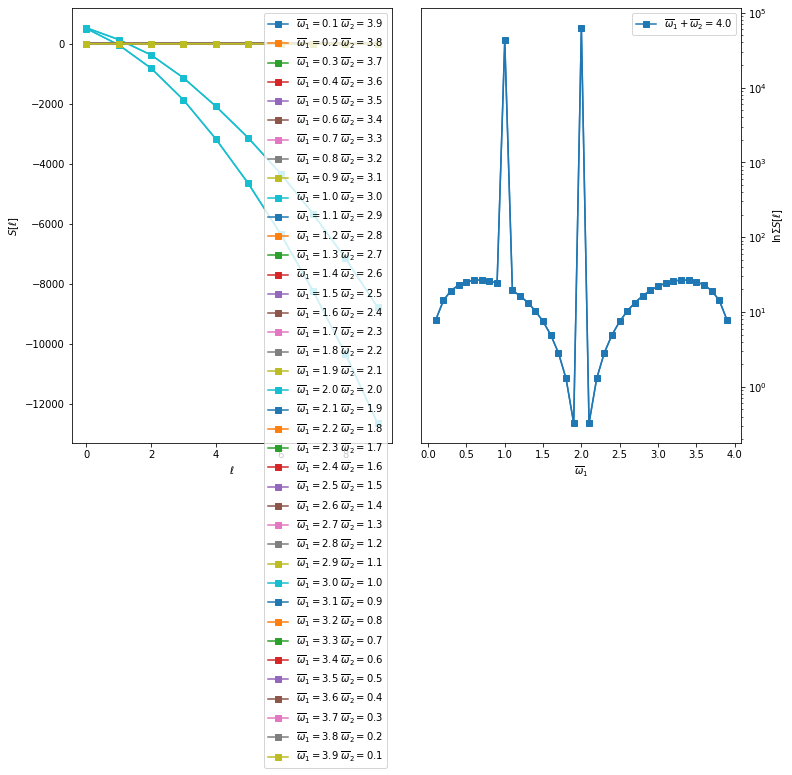

In [25]:
# Plot the results
svals = {}
totalvals = {}
# Read the data from the file. Dictionary key is the NN frequency, values are source terms S[l]
with open("NNAddToInteger.dat", "r") as f:
    lmax = 0
    tmp = []
    for line in f:
        # Read the line that contains the NN frequency value and the number of modes
        if "w1 =" in line:
            foo = line.strip().split(" = ")
            # Pick out the w1 and w2 values
            dkey = (float(foo[1].split()[0]), float(foo[2].split()[0]))
            # Pick out the l value
            lmax = int(foo[-1])
        # Catch the sum of the source terms and store in separate dictionary
        elif "Sum" in line:
            tsum = line.strip().split(" = ")
            totalvals[dkey] = float(tsum[-1])
        # Otherwise, add the value to the list for that frequency
        else:
            if lmax <= 0:
                svals[dkey] = tmp
                lmax = 0
                tmp = []
            else:
                # Lines containing separators can be skipped
                if "--" in line:
                    pass
                else:
                    bar = line.strip().split()
                    tmp.append(float(bar[-1]))
                    lmax -= 1
"""
print(svals.get((1.0,3.0)))
print(totalvals.get((1.0,3.0)))
print(svals.get((3.0,1.0)))
print(totalvals.get((3.0,1.0)))
print(svals.get((2.0,2.0)))
print(totalvals.get((2.0,2.0)))
"""

print(svals)
print(totalvals)
                    
colours = ['C' + str(val) for val in range(10)] * int((len(svals) - 1)/10 + 1)
fig = plt.figure(figsize=(12,8))
gs = GridSpec(1,4,figure=fig)
ax1 = fig.add_subplot(gs[0,:2])
ax2 = fig.add_subplot(gs[0,2:])

# Plot the source terms S[l]
ii = 0
for key in sorted(svals.keys()):
    # Test for nan values caused by division by zero
    if np.any(np.isnan(svals.get(key))):
        temp = svals.get(key)
        xvals = np.arange(len(temp))
        nanvals = np.argwhere(np.isnan(temp))
        # Remove nan values and adjust arrays accordingly
        for indx in nanvals[0]:
            print("NAN found at" + str(key) + ":", temp)
            temp = np.delete(temp, [indx])
            xvals = np.delete(xvals, [indx])
        # Recalculate sum with nan values removed
        totalvals[key] = np.sum(temp)
        # Plot adjusted source terms
        ax1.plot(xvals, temp, marker='s', markerfacecolor=colours[ii], 
                 label=r'$\overline{\omega}_1 = $' + str(key[0]) + r' $\overline{\omega}_2 = $' + str(key[1]))
        ax1.plot(xvals, temp, color=colours[ii])
        
    else:
        ax1.plot(np.arange(len(svals.get(key))), svals.get(key)[:], marker='s', markerfacecolor=colours[ii], 
                 label=r'$\overline{\omega}_1 = $' + str(key[0]) + r' $\overline{\omega}_2 = $' + str(key[1]))
        ax1.plot(np.arange(len(svals.get(key))), svals.get(key)[:], color=colours[ii])
    ii += 1
    
ax1.set_xlabel(r'$\ell$')
#ax1.set_yscale('log')
ax1.set_ylabel(r'$S[\ell]$')
ax1.legend()


# Plot sum of source terms up to LMAX in two axes
X = [key[0] for key in sorted(totalvals.keys())]
Y = [key[1] for key in sorted(totalvals.keys())]
N = X[0] + Y[0]
Z = [abs(totalvals.get(key)) for key in sorted(totalvals.keys())]

ax2.plot(X, Z, marker='s', markerfacecolor='C0', 
         label=r'$\overline{\omega}_1 + \overline{\omega}_2 = $' + str(N))
ax2.plot(X, Z, color='C0')

ax2.set_xlabel(r'$\overline{\omega}_1$')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(r'$\Sigma S[\ell]$')
ax2.set_yscale('log')
ax2.legend()


fname = "NN_equalfreq_sourceterms.pdf"
plt.savefig("figures/" + fname, transparent=True, format="pdf")
print("Saved figure as", fname)
plt.show()


In [ ]:
(1.0, 3.0): [526.9995, 135.216, -376.4858, -1140.233, -2085.56, -3135.749, -4324.924, -5658.926, -7141.394, -8774.417]

In [ ]:
(3.0, 1.0): [-0.1568388, -0.276501, -0.5834769, -0.8861125, -1.252415, -1.684815, -2.183683, -2.749091, -3.381051, -4.079562]